# Stock Price Predictor

In [470]:
# importing relevant libraries
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
import yfinance as yf


## Getting a 3 year span of SPY data

In [471]:
from datetime import date
from datetime import timedelta

years = 3

today = date.today()
prev_three_years = today - timedelta(weeks = 52*years)
print(today)
print(prev_three_years)

2024-01-14
2021-01-17


In [472]:
stock_name = 'SPY'
data = yf.download(stock_name, start = prev_three_years, end = today)

[*********************100%%**********************]  1 of 1 completed


In [473]:
print(data)

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2021-01-19  378.339996  379.230011  376.750000  378.649994  362.198761   
2021-01-20  381.109985  384.790009  380.690002  383.890015  367.211090   
2021-01-21  384.489990  384.950012  383.250000  384.239990  367.545868   
2021-01-22  382.250000  384.130005  381.839996  382.880005  366.244995   
2021-01-25  383.670013  384.769989  378.459991  384.390015  367.689362   
...                ...         ...         ...         ...         ...   
2024-01-08  468.429993  474.750000  468.299988  474.600006  474.600006   
2024-01-09  471.869995  474.929993  471.350006  473.880005  473.880005   
2024-01-10  474.160004  477.450012  473.869995  476.559998  476.559998   
2024-01-11  477.589996  478.119995  472.260010  476.350006  476.350006   
2024-01-12  477.839996  478.600006  475.230011  476.679993  476.679993   

              Volume  
Date          

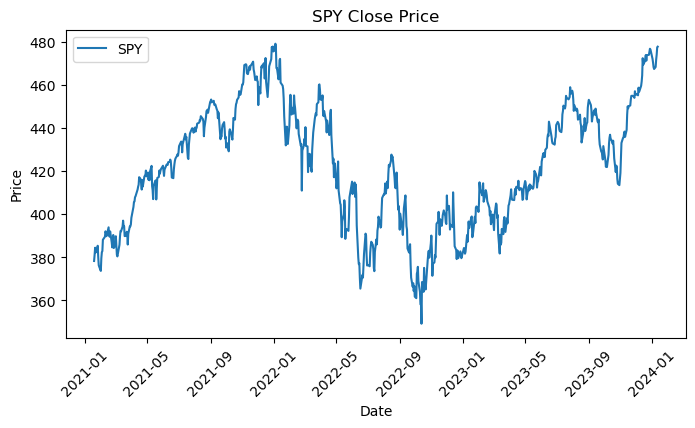

In [474]:
plt.figure(figsize = (8,4))
plt.plot(data.index, data['Open'], label = stock_name)
plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'{stock_name} Close Price')
plt.legend()
plt.show()

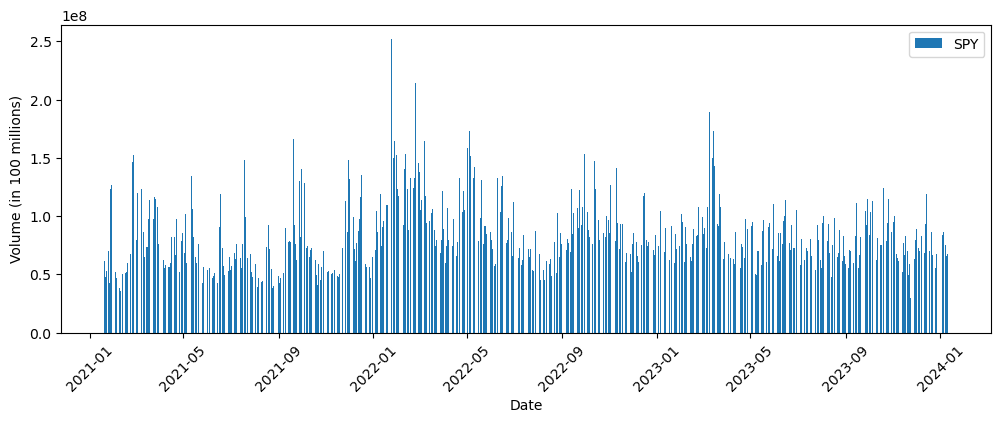

In [475]:
plt.figure(figsize = (12, 4))
plt.bar(data.index, data['Volume'], label = 'SPY')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Volume (in 100 millions)')
plt.xticks(rotation = 45)
plt.show()


## Data Preprocessing

In [476]:
from sklearn.preprocessing import MinMaxScaler
scale = MinMaxScaler()
data = data['Close']
data = data.reset_index() 
data = data.drop(columns = ['Date'])
data = np.array(data)
process_data = scale.fit_transform(data)


## Splitting into train/test 

In [477]:
train_split = 0.7

train_size = int(len(process_data)*0.7)
test_size = len(process_data) - train_size

train = process_data[:train_size]
test = process_data[-test_size:]
print(len(train))
print(len(test))


526
226


In [478]:
def create_splits(dataset, window):
    x_data = []
    y_data = []
    
    for i in range(len(dataset) - window - 1):
        data_range = dataset[i:(i+window)]
        x_data.append(data_range)
        y_data.append(dataset[i+window])
        
    return np.array(x_data), np.array(y_data)

In [479]:
window_size = 30
X_train, y_train = create_splits(train, window_size)
X_test, y_test = create_splits(test, window_size)

## Building Model

### Will be using a Long Short-Term Model due to its effictiveness with predicting patterns in time-series data

In [480]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [481]:
model = Sequential()
model.add(LSTM(50, return_sequences = True))
model.add(Dense(1))

In [482]:
model.compile(
    optimizer = 'adam',
    loss = 'mean_squared_error'
)

In [483]:
model.fit(
    x = X_train,
    y = y_train,
    epochs = 100
)

Epoch 1/100
16/16 [==============================] - 3s 7ms/step - loss: 0.1281
Epoch 2/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0489
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 0.0396
Epoch 4/100
16/16 [==============================] - 0s 4ms/step - loss: 0.0359
Epoch 5/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0336
Epoch 6/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0320
Epoch 7/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0307
Epoch 8/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0295
Epoch 9/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0287
Epoch 10/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0278
Epoch 11/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0275
Epoch 12/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 13/100
16/16 [=================

## Looking at predictions

In [484]:
from sklearn.metrics import mean_squared_error
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

training_mse = mean_squared_error(y_train, train_predict[:,0])
print(f'The training mean squared error is: {training_mse}')

testing_mse = mean_squared_error(y_test, test_predict[:,0])
print(f'The testing mean squared error is: {testing_mse}')

7/7 [==============================] - 0s 2ms/step
The training mean squared error is: 0.032677575130547164
The testing mean squared error is: 0.03167313896603141


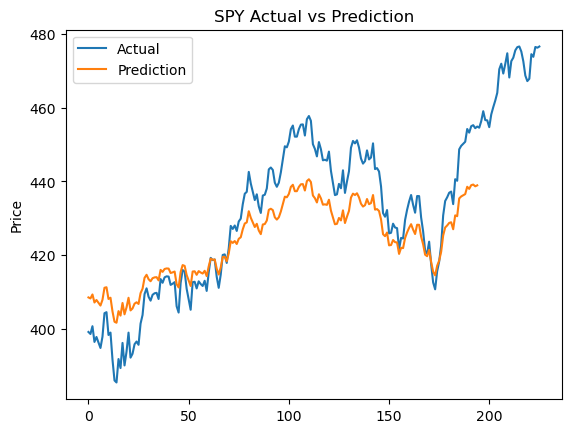

In [485]:
plt.plot(scale.inverse_transform(test), label = 'Actual')
plt.plot(scale.inverse_transform(test_predict[:,0]), label = 'Prediction')
plt.legend()
plt.ylabel('Price')
plt.title(f'{stock_name} Actual vs Prediction')
plt.show()


Here we can see that the LSTM model does a good job at predicting the trend of the price.

## Finding Current Date Prediction

In [486]:
prev_thirty = today - timedelta(days = window_size)

current_stock_data = yf.download(stock_name, start = prev_thirty, end = today)
current_close_data = np.array(current_stock_data['Close'].reset_index().drop(columns = ['Date']))
current_close_data = scale.fit_transform(current_close_data)

print(len(current_close_data))

[*********************100%%**********************]  1 of 1 completed
19


In [487]:
def create_live_split(dataset, window):
    x_data = []
    
    for i in range(len(dataset) - window - 1):
        data_range = dataset[i:(i+window)]
        x_data.append(data_range)
        
    return np.array(x_data)

In [488]:
current_x = create_live_split(current_close_data, len(current_close_data)-2)
valuation = model.predict(current_x)
future_valuation = scale.inverse_transform(valuation[:,0])
prev_day_valuation = scale.inverse_transform(current_close_data)[-1]


1/1 [==============================] - 0s 348ms/step


In [489]:
print(f"Yesterday's price was {prev_day_valuation[0]}")
print(f"The predicted price is {future_valuation[0][0]}")

Yesterday's price was 476.67999267578125
The predicted price is 470.6865234375


In [490]:
def bullish_bearish(prev, future):
    if future > prev:
        return 'Bullish'
    elif future < prev:
        return 'Bearish'
    else:
        return 'No price movement'

In [491]:
print(bullish_bearish(prev_day_valuation,future_valuation))

Bearish
